# 사용 함수 정의

In [1]:
from sqlalchemy import create_engine
from datetime import datetime
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import boto3
from plugins import connector
    
def extract_data(cur, sql):
    cur.execute(sql)
    columns = [desc[0] for desc in cur.description]
    results = cur.fetchall()
    print(f'{len(results)}행 추출 완료')
    df = pd.DataFrame(results)
    df.columns = columns
    print('데이터프레임 생성 완료')
    return df

# REDSHIFT 데이터 추출
데이터 웨어하우스에 적재된 population 데이터와 weather 데이터를 join하여 데이터를 추출하였습니다.

In [2]:
conn, cur = connector.redshift_connector()

# sql 수정 후에 사용해도 좋음
# 내가 생각하기에 쓸모 없다고 생각하는 데이터는 뺐음
sql = '''
    SELECT
        P.place_id,
        P.area_congest_id,
        P.area_ppltn_min,
        P.area_ppltn_max,
        W.temp,
        W.sensible_temp,
        W.humidity,
        W.wind_dirct,
        W.wind_spd,
        W.precipitation,
        W.uv_index_lvl,
        W.pm25,
        W.pm10,
        W.air_idx_mvl,
        W.created_date,
        DATE_PART('year', W.created_date) AS year,
        DATE_PART('month', W.created_date) AS month,
        DATE_PART('day', W.created_date) AS day,
        DATE_PART('hour', W.created_date) AS hour,
        DATE_PART('minute', W.created_date) AS minute,
        EXTRACT(DOW FROM W.created_date) AS dow
    FROM
        "raw"."population" AS P
    JOIN
        "raw"."weather" AS W ON P.place_id = W.place_id AND P.created_date = W.created_date;
    '''
    
df = extract_data(cur, sql)
df.info()

Redshift에 연결되었습니다.
39778행 추출 완료
데이터프레임 생성 완료
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39778 entries, 0 to 39777
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   place_id         39778 non-null  int64         
 1   area_congest_id  39778 non-null  int64         
 2   area_ppltn_min   39778 non-null  int64         
 3   area_ppltn_max   39778 non-null  int64         
 4   temp             39778 non-null  float64       
 5   sensible_temp    39778 non-null  float64       
 6   humidity         39778 non-null  int64         
 7   wind_dirct       39778 non-null  object        
 8   wind_spd         39778 non-null  float64       
 9   precipitation    39778 non-null  float64       
 10  uv_index_lvl     39778 non-null  int64         
 11  pm25             39778 non-null  int64         
 12  pm10             39778 non-null  int64         
 13  air_idx_mvl      39778 non-null  int64        

## 예측에 사용할 수 없는 변수 삭제 / area_congest_id - 1(xgboost 관련)
- 데이터가 한정되어 있어, year, month는 일년동안 데이터를 쌓지 않는 이상 제대로 된 변수로 사용될 수 없을 것 같아 drop 하였습니다.
- area_ppltn_min, area_ppltn_max, sensible_temp, uv_index_lvl, pm25, pm10, air_idx_mvl 컬럼은 예측 시점의 데이터를 가져오는 것이 불가능하기에 제외하였습니다.
- wind_dirct의 경우 타겟변수와 유의미한 상관관계도 발견되지 않아, 제외하였습니다.
- xgboost의 타겟변수 설정관련하여, area_congest_id를 0부터 시작하도록 조정하였습니다.

In [3]:
cannotuse_columns = ['year', 'month', 'area_ppltn_min', 'area_ppltn_max', 'sensible_temp', 'wind_dirct', 'uv_index_lvl', 'pm25', 'pm10', 'air_idx_mvl']
df = df.drop(columns = cannotuse_columns)

# area_congest_id 값 1 빼기
df['area_congest_id'] = df['area_congest_id'] - 1

## 푸리에특징을 통한 시간연속성 표현(HOUR)
- 간단한 푸리에 변환을 활용하여, hour의 시간연속성을 데이터에 표현하였습니다.

In [4]:
# 시간 관련 정보 추출
hour = df['hour'].values

# 시간 정보를 하나의 특징으로 합치기
time_feature = hour / 24

# 주기성을 나타내는 푸리에 특징 계산
time_rad = 2 * np.pi * time_feature

fourier_features = np.column_stack([
    np.cos(time_rad), np.sin(time_rad)
])

# 생성된 특징을 데이터프레임에 추가
df['fourier_cos_time'] = fourier_features[:, 0]
df['fourier_sin_time'] = fourier_features[:, 1]

# 기존 시간 관련 컬럼 제거
df = df.drop(columns=['day','hour','minute'])
df


,place_id,area_congest_id,temp,humidity,wind_spd,precipitation,created_date,dow,fourier_cos_time,fourier_sin_time
0,18,0,22.5,51,3.1,0.0,2023-06-03 19:30:00,6,0.258819,-0.965926
1,45,0,22.5,51,3.1,0.0,2023-06-03 19:30:00,6,0.258819,-0.965926
2,48,2,23.9,38,2.1,0.0,2023-06-03 19:30:00,6,0.258819,-0.965926
3,3,0,23.2,38,2.2,0.0,2023-06-03 19:30:00,6,0.258819,-0.965926
4,5,1,23.1,38,0.9,0.0,2023-06-03 19:30:00,6,0.258819,-0.965926
...,...,...,...,...,...,...,...,...,...,...
39773,25,0,20.5,79,0.3,0.0,2023-06-22 00:30:00,4,1.000000,0.000000
39774,31,0,20.4,80,0.1,0.0,2023-06-22 00:30:00,4,1.000000,0.000000
39775,35,0,20.2,79,1.6,0.0,2023-06-22 00:30:00,4,1.000000,0.000000
39776,20,0,17.9,96,0.1,0.0,2023-06-22 00:30:00,4,1.000000,0.000000


## 휴일 컬럼 추가
공휴일인 경우 1의 값을 가집니다. 아닌 경우는 모두 0입니다.

In [5]:
# 휴일 관련 컬럼을 정의합니다.
holiday_list = joblib.load('C:/last_project/ML/data/holiday.pkl')

# created_date 컬럼을 datetime 형식으로 변환
df['created_date'] = pd.to_datetime(df['created_date'])

# holiday인 값을 디폴트 값 0으로 설정
df['holiday'] = 0

# created_date가 holiday_list에 포함된 날짜인 경우, holiday 컬럼을 1로 변경
df.loc[df['created_date'].dt.strftime('%Y-%m-%d').isin(holiday_list), 'holiday'] = 1

df = df.drop(columns = 'created_date')
df

,place_id,area_congest_id,temp,humidity,wind_spd,precipitation,dow,fourier_cos_time,fourier_sin_time,holiday
0,18,0,22.5,51,3.1,0.0,6,0.258819,-0.965926,0
1,45,0,22.5,51,3.1,0.0,6,0.258819,-0.965926,0
2,48,2,23.9,38,2.1,0.0,6,0.258819,-0.965926,0
3,3,0,23.2,38,2.2,0.0,6,0.258819,-0.965926,0
4,5,1,23.1,38,0.9,0.0,6,0.258819,-0.965926,0
...,...,...,...,...,...,...,...,...,...,...
39773,25,0,20.5,79,0.3,0.0,4,1.000000,0.000000,0
39774,31,0,20.4,80,0.1,0.0,4,1.000000,0.000000,0
39775,35,0,20.2,79,1.6,0.0,4,1.000000,0.000000,0
39776,20,0,17.9,96,0.1,0.0,4,1.000000,0.000000,0


# 원핫인코딩
범주형 변수인 place_id와 dow(요일)을 원핫인코딩 처리하였습니다. 그 외에는 전부 연속형 변수입니다.(타겟변수인 area_congest_id는 제외)

In [7]:
onehot_features = ['place_id', 'dow']

# one-hot encoding 수행
df = pd.get_dummies(df, columns=onehot_features, dummy_na=False)
df

,area_congest_id,temp,humidity,wind_spd,precipitation,fourier_cos_time,fourier_sin_time,holiday,place_id_1,place_id_2,...,place_id_46,place_id_47,place_id_48,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,0,22.5,51,3.1,0.0,0.258819,-0.965926,0,False,False,...,False,False,False,False,False,False,False,False,False,True
1,0,22.5,51,3.1,0.0,0.258819,-0.965926,0,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2,23.9,38,2.1,0.0,0.258819,-0.965926,0,False,False,...,False,False,True,False,False,False,False,False,False,True
3,0,23.2,38,2.2,0.0,0.258819,-0.965926,0,False,False,...,False,False,False,False,False,False,False,False,False,True
4,1,23.1,38,0.9,0.0,0.258819,-0.965926,0,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39773,0,20.5,79,0.3,0.0,1.000000,0.000000,0,False,False,...,False,False,False,False,False,False,False,True,False,False
39774,0,20.4,80,0.1,0.0,1.000000,0.000000,0,False,False,...,False,False,False,False,False,False,False,True,False,False
39775,0,20.2,79,1.6,0.0,1.000000,0.000000,0,False,False,...,False,False,False,False,False,False,False,True,False,False
39776,0,17.9,96,0.1,0.0,1.000000,0.000000,0,False,False,...,False,False,False,False,False,False,False,True,False,False


# 모델 학습 및 예측
- nested_cross_validation을 활용하여, 시계열 데이터의 특성을 살려 검증하였습니다.
- 상위 모델로는 CATBOOST, XGBOOST, LGBM, RANDOMFOREST를 선정하였으며 해당 결과는 튜닝 전 모델의 예측 성능에 근거하였습니다.

LogisticRegression : 0.7825929507324856점
DecisionTreeClassifier : 0.8568787191906206점
RandomForestClassifier : 0.8826232398872618점
Learning rate set to 0.094398
0:	learn: 1.2364205	total: 152ms	remaining: 2m 32s
1:	learn: 1.1276600	total: 163ms	remaining: 1m 21s
2:	learn: 1.0442863	total: 172ms	remaining: 57.3s
3:	learn: 0.9792122	total: 195ms	remaining: 48.6s
4:	learn: 0.9273805	total: 205ms	remaining: 40.7s
5:	learn: 0.8817006	total: 227ms	remaining: 37.5s
6:	learn: 0.8447144	total: 235ms	remaining: 33.4s
7:	learn: 0.8141840	total: 245ms	remaining: 30.4s
8:	learn: 0.7873881	total: 254ms	remaining: 27.9s
9:	learn: 0.7638000	total: 269ms	remaining: 26.6s
10:	learn: 0.7420504	total: 284ms	remaining: 25.5s
11:	learn: 0.7238329	total: 293ms	remaining: 24.2s
12:	learn: 0.7067691	total: 302ms	remaining: 22.9s
13:	learn: 0.6919726	total: 315ms	remaining: 22.2s
14:	learn: 0.6784206	total: 325ms	remaining: 21.3s
15:	learn: 0.6668249	total: 333ms	remaining: 20.5s
16:	learn: 0.6564767	total: 343

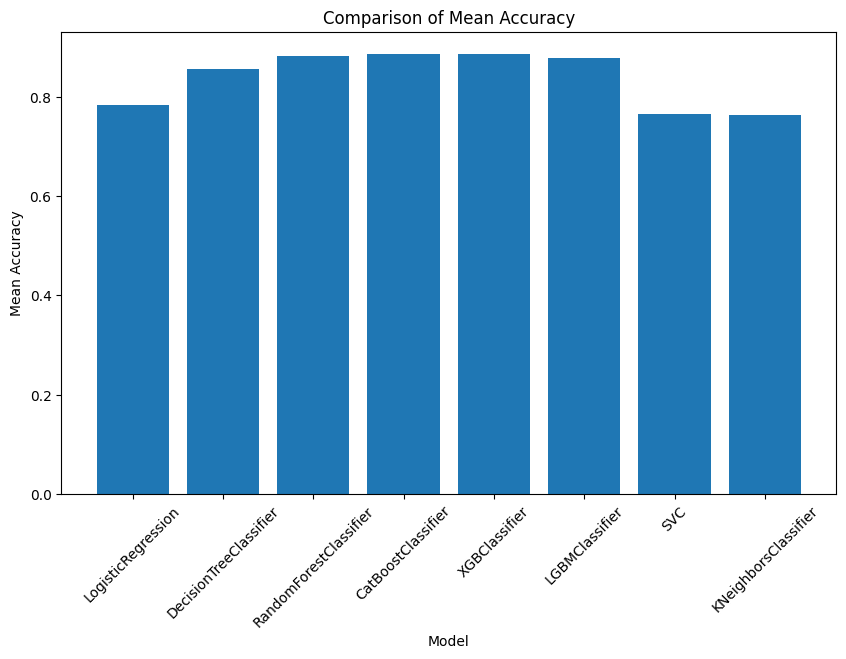

In [8]:
# 특성과 타겟 데이터 분할
X = df.drop(columns = 'area_congest_id')
y = df['area_congest_id']

# 변수 초기화
accuracy_scores = []

# 모델 리스트 생성
models = [
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42),
    CatBoostClassifier(random_state=42),
    XGBClassifier(random_state=42),
    LGBMClassifier(random_state=42),
    SVC(random_state=42),
    KNeighborsClassifier()
]

# 교차 검증 수행 및 결과 저장
for model in models:
    scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross validation
    mean_score = scores.mean()
    accuracy_scores.append(mean_score)
    print(f'{model.__class__.__name__} : {mean_score}점')
    

# 결과 시각화
model_names = [model.__class__.__name__ for model in models]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores)
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.title('Comparison of Mean Accuracy')
plt.xticks(rotation=45)
plt.show()

# CATBOOST, LGBM, XGBOOST의 특성중요도
- 특성중요도 분석을 통해, 세 모델 전부 강수량이 중요하지 않은 결과를 보였습니다. 이 부분은 한달간 비오는 날이 적었던 이유를 들어, 해당 컬럼은 남겨두는 것으로 정하였습니다.
- 이 중 CATBOOST는 변수의 영향력을 골고루 판단하고, 특히 fourier 관련 변수의 중요도를 높게 선정하여 시간과 관련된 장소 혼잡도 예측 결과를 유의미하게 다뤘다고 판단하였습니다.
- LGBM은 우월한 학습 속도 및 변수의 영향력을 골고루 판단하였지만, 분석가의 판단 하에 place 관련 변수 만큼 fourier 관련 변수(hour)의 중요도를 높게 보고 있기에, 우선순위는 CATBOOST에 두었습니다.
- XGBOOST는 place 관련 변수에 의존하는 경향이 있어, 이번 예측 모델로는 제외하였습니다.

### CATBOOST

Learning rate set to 0.094595
0:	learn: 1.2359027	total: 11.1ms	remaining: 11.1s
1:	learn: 1.1276357	total: 21.4ms	remaining: 10.7s
2:	learn: 1.0458485	total: 31.2ms	remaining: 10.4s
3:	learn: 0.9804157	total: 41.4ms	remaining: 10.3s
4:	learn: 0.9274094	total: 51.4ms	remaining: 10.2s
5:	learn: 0.8826975	total: 60.6ms	remaining: 10s
6:	learn: 0.8460352	total: 70ms	remaining: 9.94s
7:	learn: 0.8153046	total: 78.8ms	remaining: 9.77s
8:	learn: 0.7884950	total: 86.9ms	remaining: 9.57s
9:	learn: 0.7645328	total: 98.9ms	remaining: 9.79s
10:	learn: 0.7447765	total: 109ms	remaining: 9.83s
11:	learn: 0.7275955	total: 120ms	remaining: 9.86s
12:	learn: 0.7116729	total: 129ms	remaining: 9.83s
13:	learn: 0.6975924	total: 141ms	remaining: 9.91s
14:	learn: 0.6838299	total: 151ms	remaining: 9.89s
15:	learn: 0.6726356	total: 161ms	remaining: 9.88s
16:	learn: 0.6615282	total: 172ms	remaining: 9.93s
17:	learn: 0.6524646	total: 181ms	remaining: 9.9s
18:	learn: 0.6445658	total: 191ms	remaining: 9.85s
19:	le

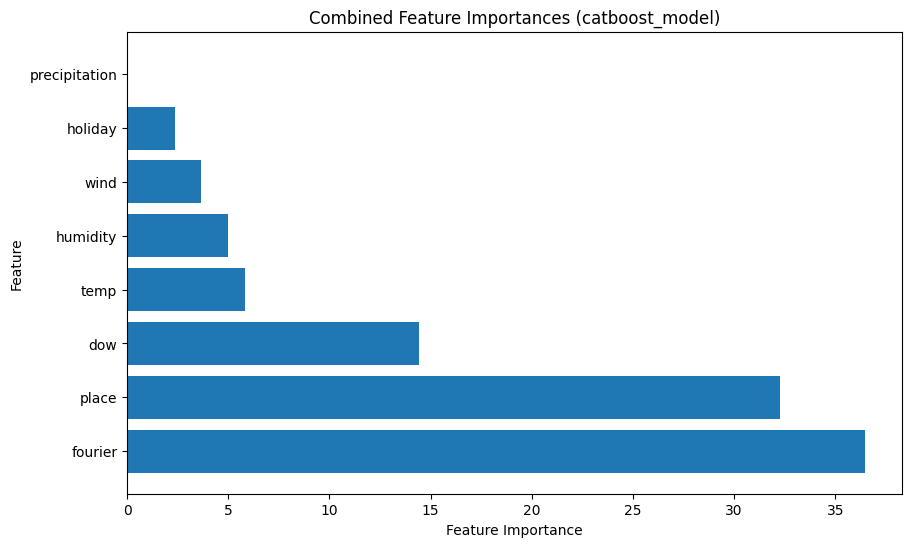

In [28]:
# Train the CatBoostClassifier model
catboost_model = CatBoostClassifier(random_state=42)
catboost_model.fit(X_train, y_train)

# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Get original feature names (without one-hot encoding)
original_feature_names = [col.split('_')[0] for col in X_train.columns]

# Create a dictionary to store the combined feature importances
combined_feature_importances = {}

# Iterate over the feature importances and sum them for the original feature names
for feature_name, importance in zip(X_train.columns, feature_importances):
    original_feature_name = feature_name.split('_')[0]
    if original_feature_name in combined_feature_importances:
        combined_feature_importances[original_feature_name] += importance
    else:
        combined_feature_importances[original_feature_name] = importance

# Convert the combined feature importances dictionary to a DataFrame
importance_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['Importance'], align='center')
plt.yticks(range(len(importance_df)), importance_df.index)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Combined Feature Importances (One-Hot Encoded Variables)')
plt.show()

### LGBM

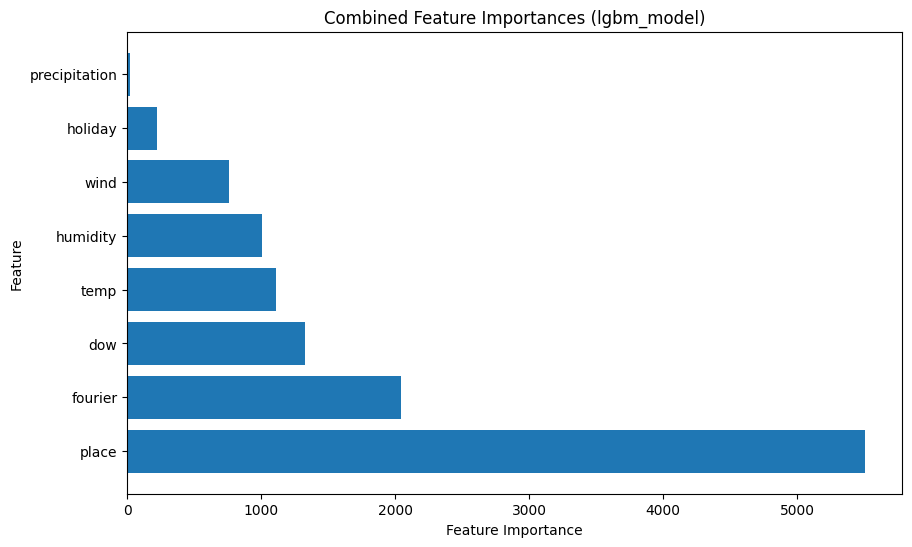

In [29]:
# Train the LGBM model
lgbm_model = lgb.LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

# Get feature importances
feature_importances = lgbm_model.feature_importances_

# Get original feature names (without one-hot encoding)
original_feature_names = [col.split('_')[0] for col in X_train.columns]

# Create a dictionary to store the combined feature importances
combined_feature_importances = {}

# Iterate over the feature importances and sum them for the original feature names
for feature_name, importance in zip(X_train.columns, feature_importances):
    original_feature_name = feature_name.split('_')[0]
    if original_feature_name in combined_feature_importances:
        combined_feature_importances[original_feature_name] += importance
    else:
        combined_feature_importances[original_feature_name] = importance

# Convert the combined feature importances dictionary to a DataFrame
importance_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['Importance'], align='center')
plt.yticks(range(len(importance_df)), importance_df.index)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Combined Feature Importances (lgbm_model)')
plt.show()


### XGBOOST

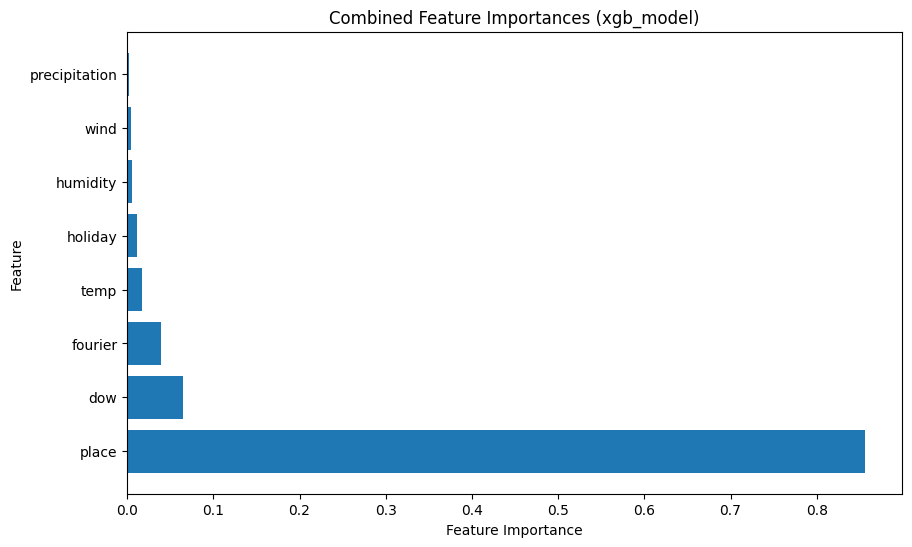

In [30]:
# Train the XGBClassifier model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Get original feature names (without one-hot encoding)
original_feature_names = [col.split('_')[0] for col in X_train.columns]

# Create a dictionary to store the combined feature importances
combined_feature_importances = {}

# Iterate over the feature importances and sum them for the original feature names
for feature_name, importance in zip(X_train.columns, feature_importances):
    original_feature_name = feature_name.split('_')[0]
    if original_feature_name in combined_feature_importances:
        combined_feature_importances[original_feature_name] += importance
    else:
        combined_feature_importances[original_feature_name] = importance

# Convert the combined feature importances dictionary to a DataFrame
importance_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['Importance'], align='center')
plt.yticks(range(len(importance_df)), importance_df.index)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Combined Feature Importances (xgb_model)')
plt.show()